# NYC MoMA Artworks - Collections In-take and Space-use Forecasting

## Table of Contents
<ol>
  <li><a href="#load-libraries">Load libraries</a></li>
  <li><a href="#data-process">Data Preprocessing</a></li>
  <li><a href="#ts-decomp">Overall Time Series Decomposition</a></li>
  <li><a href="#spatial">Spatial Time Series Analysis</a></li>
  <ol>
    <li><a href="#spatial-ts">Analysis of Space-use over Time</a></li>
  </ol>
  <li><a href="#ts-model-declare">Time Series Model Initialization</a></li>
  <li><a href="#ts-model">Time Series Model Comparisons</a></li>
  <ol>
    <li><a href="#ts-model-tv">Time Series Model Training & Validation</a></li>
    <li><a href="#ts-model-forecast">Time Series Forecasting Estimates</a></li>
  </ol>
  <li><a href="#conclusions">Conclusions</a></li>
  <li><a href="#recommendations">Recommendations</a></li>
</ol>

<section id="load-libraries">
    <h2>Load Libraries</h2>
</section>

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mode
from darts import TimeSeries
from darts.models import NaiveDrift, NaiveMovingAverage, ExponentialSmoothing, Croston, CatBoostModel, RandomForest
from darts.explainability.shap_explainer import ShapExplainer
from darts.utils.statistics import check_seasonality, stationarity_tests, plot_residuals_analysis, fill_missing_values
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.metrics import r2_score, mae, mase, ope
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import matplotlib.pyplot as plt

In [2]:
# Define Necessary Functions
def remove_outliers(dataset, lower = 0.25, upper = 0.75):
    # Remove numerical outliers from the dataset
    dataset.astype(np.float64)
    Q1 = dataset.quantile(lower)
    Q3 = dataset.quantile(upper)
    IQR = Q3 - Q1
    lower_outliers = Q1 - (1.5 * IQR)
    upper_outliers = Q3 + (1.5 * IQR)

    return dataset[(dataset > lower_outliers) & (dataset < upper_outliers)]


def gen_ts_features(df, date_column, more_columns):
    # Generates Time Series Features based on date_column
    # Makes for easier analysis of operational (day-to-day) processes.
    out = df[[date_column] + more_columns].copy()
    out[date_column] = pd.to_datetime(out[date_column], format = "%m/%d/%Y", errors = "coerce")
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    out["weekday"] = pd.Categorical(out[date_column].dt.day_name(), categories = weekday_order, ordered = True)
    out["day_of_month"] = out[date_column].dt.day.astype(int)
    out["day_of_year"] = out[date_column].dt.dayofyear.astype(int)
    out["week_of_month"] = (out[date_column].dt.day / 7).apply(lambda x: np.ceil(x)).astype(int)
    out["week"] = out[date_column].dt.isocalendar().week.astype(int)
    out["month"] = out[date_column].dt.month.astype(int)
    out["year"] = out[date_column].dt.isocalendar().year.astype(int)
    return out


def is_stationary(series):
    # Hypothesis Testing for Time Series data
    # Perform two separate stationarity tests
    result = stationarity_tests(series, p_value_threshold_adfuller=0.05, p_value_threshold_kpss=0.05)

    if result:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")
    return result


def has_seasonality(series):
    result = check_seasonality(series)

    if result[0]:
        print(f"The time series has seaonality, with a period of {result[1]}")
    else:
        print("The time series does not have seasonality.")
    return result

In [3]:
# Data Preprocessing
dataset = (pd.read_csv("NYC-MoMA-Recent-Collections_TS.csv", index_col=0)
.sort_values("acquisition_date")
.drop(columns =["acc_gaps"])
)
dataset.loc[:, "adate_sum"] = pd.to_numeric(dataset["adate_sum"], errors="coerce")
clean_dataset = (dataset.astype({
    "acquisition_date": "datetime64[ns]",
    # "date": "datetime64[ns]",
    "department": "category",
    "credit_group": "category",
    "storage_group": "category",
    # "day_of_month": "category",
    # "day_of_year": "category",
    # "week": "category",
    # "month": "category",
    # "year": "category",
    "weekday": "category",
    })
    .drop(columns = ["height_ft", "width_ft", "depth_ft", "cubic_ft", "spatial_running_total"]))
# clean_dataset["date"] = pd.Categorical(clean_dataset["date"].dt.strftime("%Y"))

# Merge exogenous columns back onto groupby
# adate_groupby = clean_dataset.groupby("acquisition_date").agg({"adate_sum": "sum", "date": lambda x: mode(x) if not mode(x) == "" else None, "weekday": lambda x: mode(x)[0] if not mode(x) == "" else None}).reset_index()
adate_groupby = (clean_dataset.set_index("acquisition_date").resample("D").agg({
    "adate_sum": "sum",
    "day_of_month": "mean",
    "day_of_year": "mean",
    "week": "mean",
    "month": "mean",
    "year": "mean",
    # "date": lambda x: x.mode()[0] if not x.mode().empty else None,
    "department": lambda x: x.mode()[0] if not x.mode().empty else None,
    "credit_group": lambda x: x.mode()[0] if not x.mode().empty else None,
    "storage_group": lambda x: x.mode()[0] if not x.mode().empty else None,
    "weekday": lambda x: x.mode()[0] if not x.mode().empty else None,
    # "day_of_month": "first",
    # "day_of_year": "first",
    # "week_of_month": "first",
    # "week": "first",
    # "month": "first",
    # "year": "first",
    # "weekday": lambda x: x.mode()[0] if not x.mode().empty else None,
}).reset_index())
# adate_groupby = adate_groupby.astype({"acquisition_date": "datetime64[ns]"})

adate_groupby = adate_groupby.astype({
    # "date": "category",
    "day_of_month": "float",
    "day_of_year": "float",
    "week": "float",
    "month": "float",
    "year": "float",
})

In [4]:
adate_groupby.dtypes

acquisition_date    datetime64[ns]
adate_sum                  float64
day_of_month               float64
day_of_year                float64
week                       float64
month                      float64
year                       float64
department                category
credit_group              category
storage_group             category
weekday                   category
dtype: object

In [5]:
total_nulls = adate_groupby.isna().sum()
total_nulls

acquisition_date       0
adate_sum              0
day_of_month        9979
day_of_year         9979
week                9979
month               9979
year                9979
department          9979
credit_group        9979
storage_group       9979
weekday             9979
dtype: int64

In [6]:
print("Total number of null records:", max(total_nulls))
print("Null record density (%):  {:0.3f}%".format(max(total_nulls) / adate_groupby.shape[0]))

Total number of null records: 9979
Null record density (%):  0.911%


In [7]:
# clean_dataset["acquisition_date"] = pd.DatetimeIndex(clean_dataset["acquisition_date"])
adate_groupby["acquisition_date"] = pd.DatetimeIndex(adate_groupby["acquisition_date"])
# dataset.index = dataset.set_index("acquisition_date")
# adate_groupby.index = adate_groupby.set_index("acquisition_date")
# dataset = dataset.drop(columns = ["acquisition_date"])
# adate_groupby = adate_groupby.drop(columns = ["acquisition_date"])

# merged = adate_groupby.merge(clean_dataset, on = ["acquisition_date", "adate_sum"], how = "outer")
# # merged = adate_groupby.merge(clean_dataset, on = ["date", "weekday", "adate_sum"], how = "outer")
# merged["adate_sum"] = merged["adate_sum"].fillna(0)
# clean_dataset["adate_sum"] = clean_dataset["adate_sum"].fillna(0)
# clean_dataset["date"] = clean_dataset["date"].fillna(clean_dataset["date"].mode()[0])

# Encode categorical columns as integers
label_encoders = defaultdict()
for column in ["department", "credit_group", "storage_group"]:
    le = LabelEncoder()
    adate_groupby[column] = le.fit_transform(adate_groupby[column])
    label_encoders[column] = le

oe = OrdinalEncoder()
adate_groupby["weekday"] = oe.fit_transform(np.array(adate_groupby["weekday"]).reshape(1, -1)).reshape(-1, 1)
label_encoders["weekday_ordinal"] = oe


for column in adate_groupby.columns.difference(["acquisition_date", "date"]):
    categorical_imputer = KNNImputer(n_neighbors = 7)
    adate_groupby.loc[:, column] = categorical_imputer.fit_transform(np.array(adate_groupby[column]).reshape(-1, 1))

# Adding lag features
lags = [1, 2, 3, 4, 5]  # Number of lags to create
for lag in lags:
    adate_groupby[f'adate_sum_lag_{lag}'] = adate_groupby['adate_sum'].shift(lag)

In [8]:
adate_groupby.isna().sum()

acquisition_date    0
adate_sum           0
day_of_month        0
day_of_year         0
week                0
month               0
year                0
department          0
credit_group        0
storage_group       0
weekday             0
adate_sum_lag_1     1
adate_sum_lag_2     2
adate_sum_lag_3     3
adate_sum_lag_4     4
adate_sum_lag_5     5
dtype: int64

In [9]:
# Dataset comparison - Record Loss
records = adate_groupby.shape[0]
final_dataset = adate_groupby.dropna().drop_duplicates("acquisition_date")
# final_dataset = final_dataset.drop(columns = ["weekday", "date"])
no_nulls = final_dataset.shape[0]

In [10]:
print("Number of Records before dropping nulls:", records)
print("Number of Records after dropping nulls:", no_nulls)
print("\n# of Records dropped: {:.2f}".format(np.abs(no_nulls - records)))
print("% of Records dropped: {:.2f}%".format((records - no_nulls) / (records)*100))

Number of Records before dropping nulls: 10956
Number of Records after dropping nulls: 10951

# of Records dropped: 5.00
% of Records dropped: 0.05%


In [11]:
# Non-count variables
exogenous_columns = [
    # "day_of_month", "week_of_month", "month", "weekday",
    "department", "credit_group", "storage_group", 
    "adate_sum_lag_1", "adate_sum_lag_2", "adate_sum_lag_3",
    "adate_sum_lag_4", "adate_sum_lag_5"
]
final_dataset["acquisition_date"] = pd.to_datetime(final_dataset["acquisition_date"])
exogenous_series = TimeSeries.from_dataframe(final_dataset, "acquisition_date", exogenous_columns, fill_missing_dates=True, freq="D")
target_series = TimeSeries.from_dataframe(final_dataset, "acquisition_date",  "adate_sum", fill_missing_dates=True, freq="D")

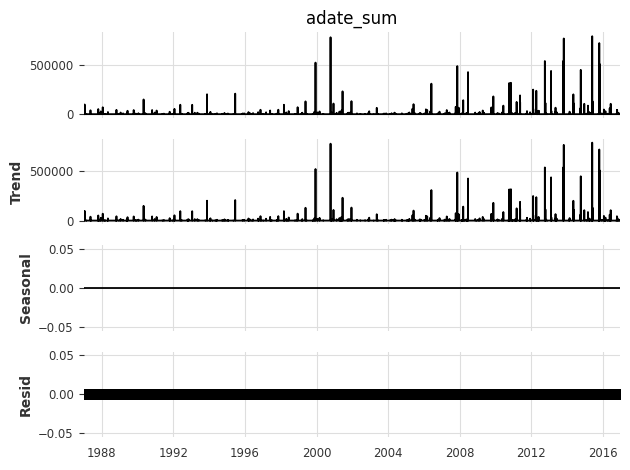

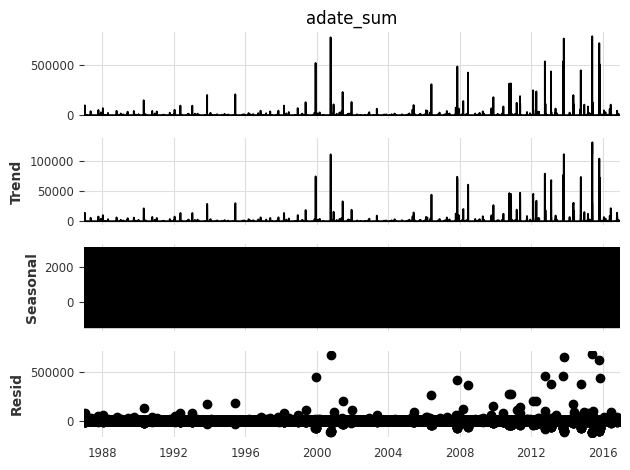

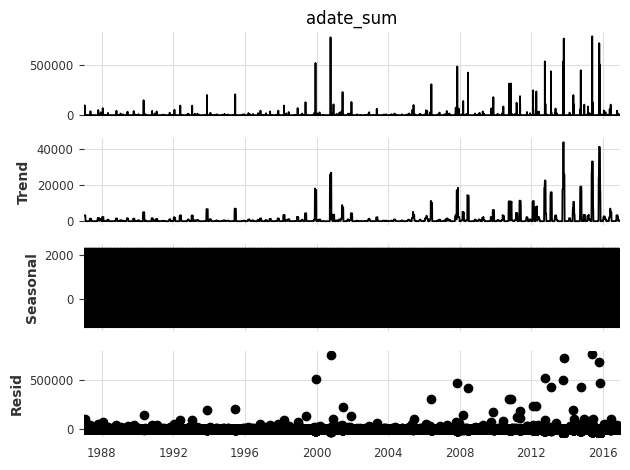

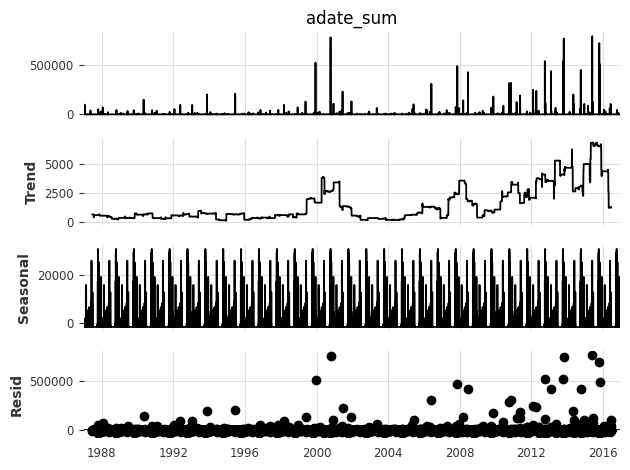

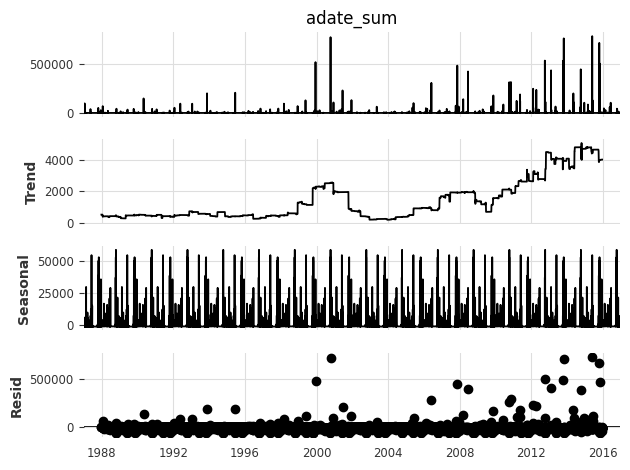

In [12]:
# Overall TS Decomposition
for days in [1, 7, 30, 365, (365 * 2)]:  # Plotting against daily observations with daily, weekly, monthly, yearly, and bi-yearly seasonality respectively.
    ts_data = final_dataset.set_index("acquisition_date").sort_index()["adate_sum"]
    decomp = sm.tsa.seasonal_decompose(ts_data, period = days)
    decomp.plot();

In [13]:
# Time Series Model Comparison Setup
lags = [-1, -2, -3, -4, -5]
models = {
    # Baseline Statistical Models
    "Naive": NaiveDrift(),
    "7-day Moving Average": NaiveMovingAverage(7),  # Naive Weekly Moving Average
    "14-day Moving Average": NaiveMovingAverage(14),  # Naive Biweekly Moving Average
    "30-day Moving Average": NaiveMovingAverage(30),  # Naive Monthly Moving Average
    "1/2-Year Moving Average": NaiveMovingAverage((365//2)),  # Naive Half-Year Moving Average
    "1-Year Moving Average": NaiveMovingAverage(365),  # Naive Yearly Moving Average
    "Exponential Smoothing": ExponentialSmoothing(trend = ModelMode.ADDITIVE, seasonal = SeasonalityMode.ADDITIVE, 
                                                  seasonal_periods = (365 * 2), random_state = 10),
    
    # Domain Specific Models - Intermittent Demand Forecasting
    "CROSTON Method": Croston(version = "optimized"),  # Modern Implementation of CROSTON
    "SBA": Croston(version = "sba"), # Syntetos-Boylan Approximation
    "TSB": Croston(version = "tsb", alpha_d = 0.1, alpha_p = 0.1), # Teunter-Syntetos-Babai

    # Multivariate ML models - Explainability metrics available
    "CatBoost": CatBoostModel(lags = lags, output_chunk_length = 10, lags_past_covariates = 5, 
                                random_state = 10, n_estimators=1500,
                                verbose=True, early_stopping_rounds = 300, objective = "RMSE",
                                eval_metric = "MAE", depth = 4, learning_rate = 0.1, task_type = "CPU"),
}

In [14]:
date_offset = clean_dataset["acquisition_date"].max() - pd.DateOffset(years = 10)

print(f"Training using data from before: {date_offset}")
print(f"and after: {clean_dataset['acquisition_date'].min()}")

Training using data from before: 2006-12-15 00:00:00
and after: 1986-12-18 00:00:00


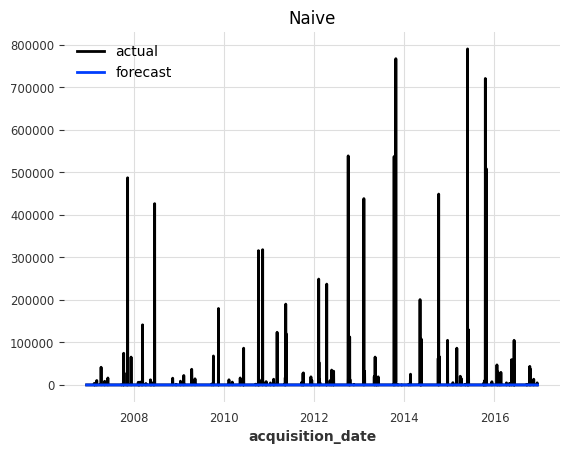

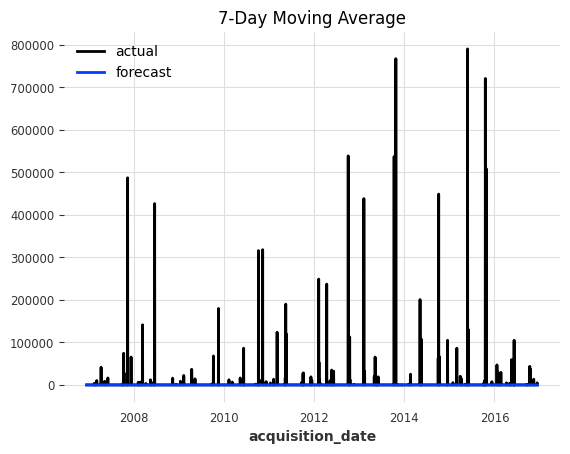

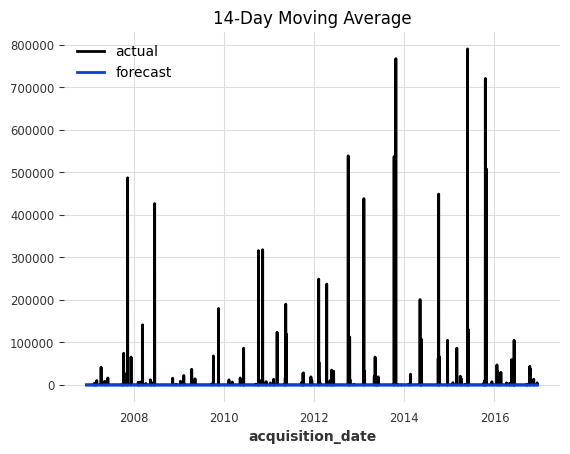

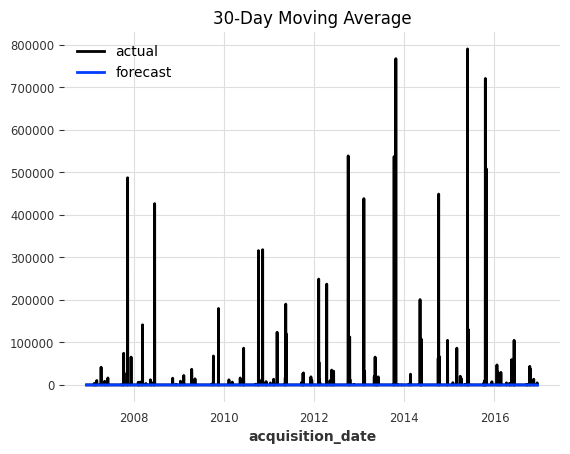

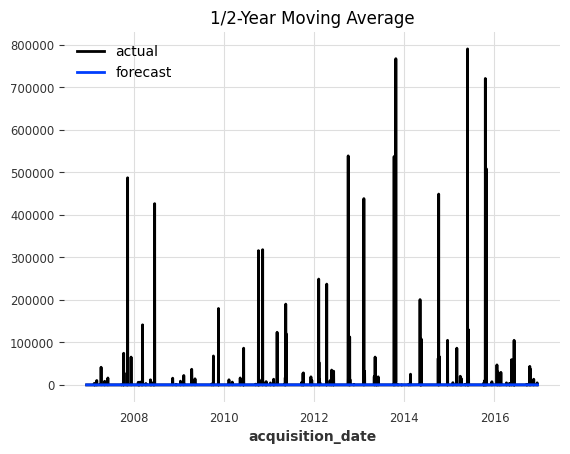

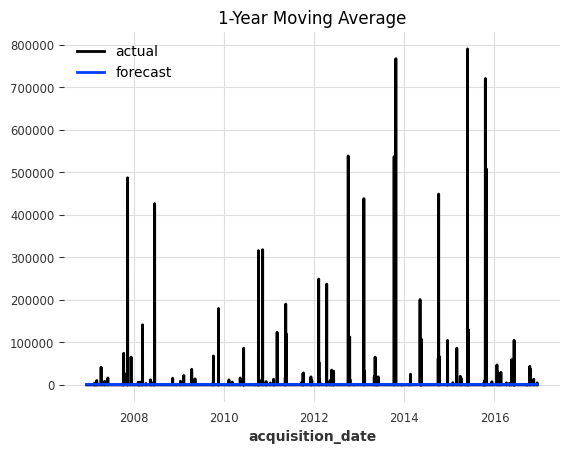

c:\Users\lilyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


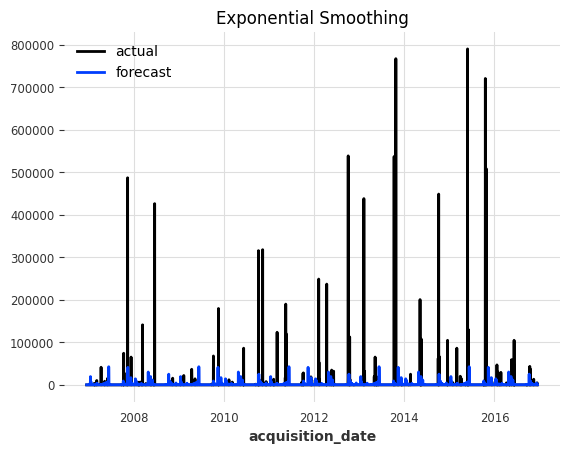

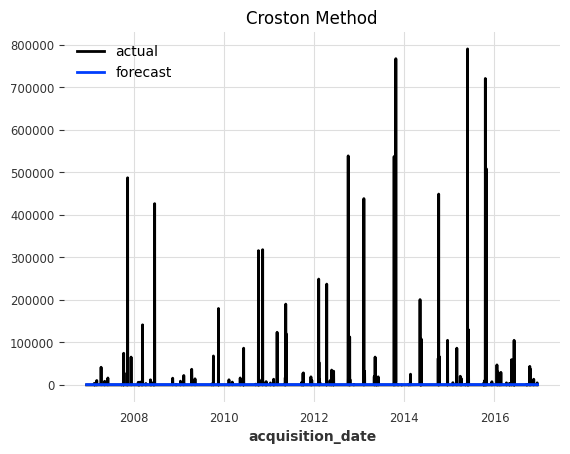

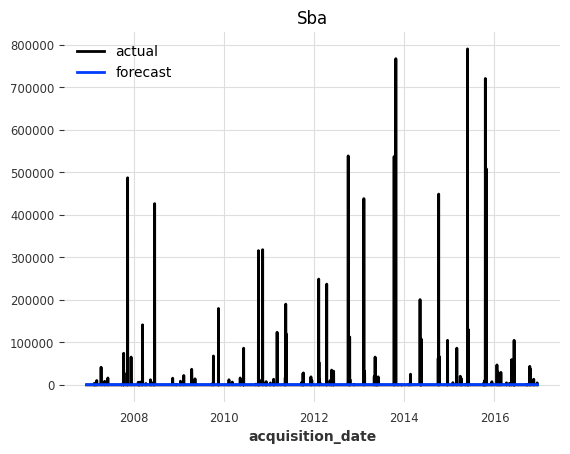

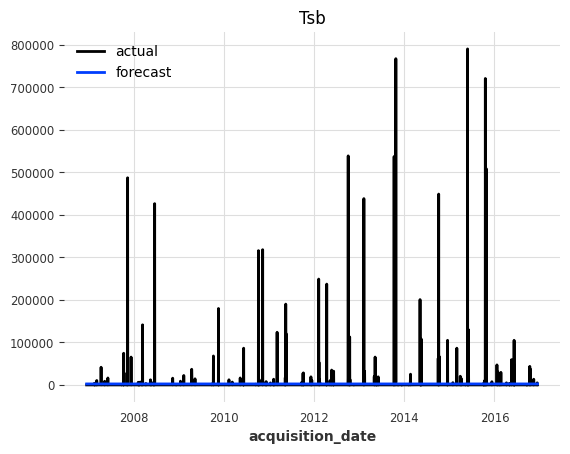

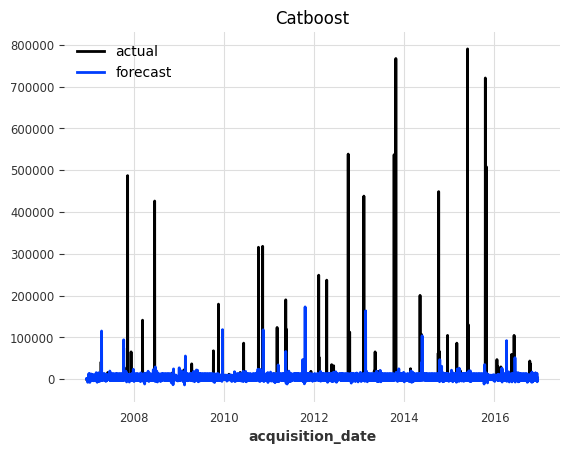

In [15]:
# Comparing Models for Selection
results = defaultdict()

# How many periods to forecast out to
forecast_windows = [5, 10, 15, 20, 30, 50, 70, 100]

# Estimating forecasts using historical data
for model_name, model in models.items():
    # for window in forecast_windows:
    train, val = target_series.split_before(date_offset)
    train = fill_missing_values(train, 0.0)
    val = fill_missing_values(val, 0.0)

    if model_name in ["Decision Tree", "Random Forest", "CatBoost"]:
        model.fit(train, past_covariates = exogenous_series)
    
    # if model_name == "Exponential Smoothing":
    #     model.fit(train)
    else:
        model.fit(train)

    if model_name == "CatBoost":
        predictions = model.predict(n = len(val), past_covariates = exogenous_series, verbose = True, show_warnings = False)
    else:
        predictions = model.predict(n = len(val))
    
    val.plot(label="actual")
    predictions.plot(label="forecast")
    plt.title(model_name.title())
    plt.show()
    plt.close()

    # Metrics selected for model selection
    # mae = mae(val, predictions)
    # mse = mase(val, predictions)
    # r2 = r2(val, predictions)
    # rmse = np.sqrt(mean_squared_error(val, predictions))
    
    # Calculate Coverage Probability (assuming a 95% prediction interval)
    # z_score = 1.96
    # lower_bound = predictions - (z_score * np.std(predictions))
    # upper_bound = predictions + (z_score * np.std(predictions))
    # coverage_probability = np.mean((val >= lower_bound) & (val <= upper_bound))

    # # Store all results
    # results["Model"].append(model_name)
    # results["Forecast Steps"].append(step_count)
    # results["MAE"].append(mae)
    # results["MSE"].append(mse)
    # results["RMSE"].append(rmse)
    # results["R2"].append(r2_score)
    # results["Coverage Probability"].append(coverage_probability)
    # results["Predictions"].append(predictions.values())

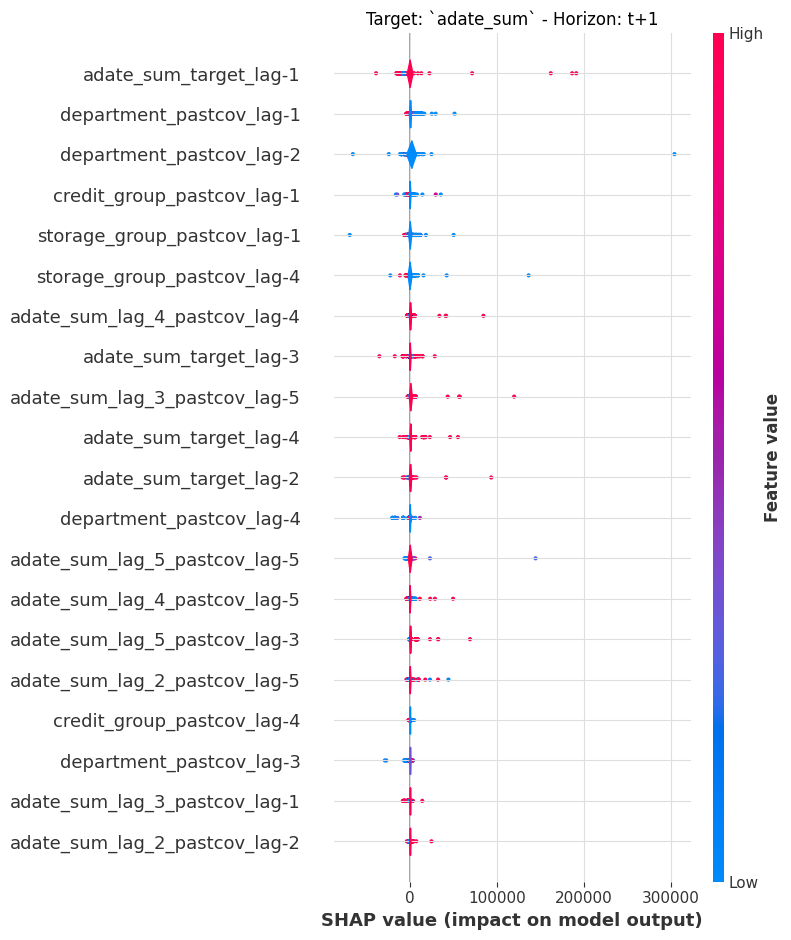

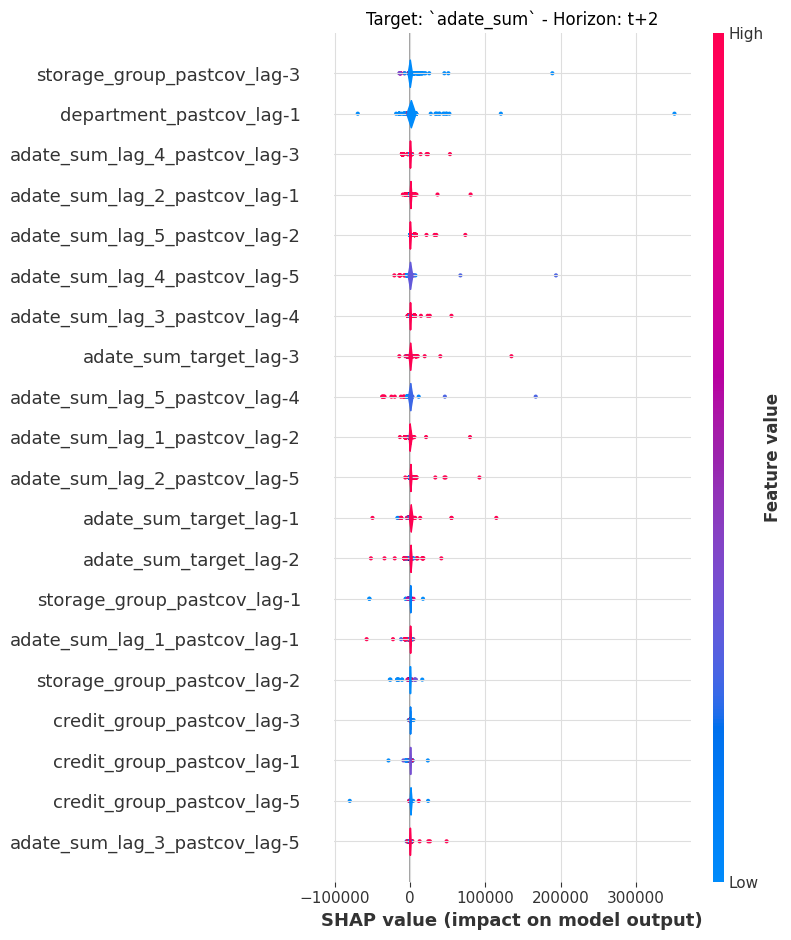

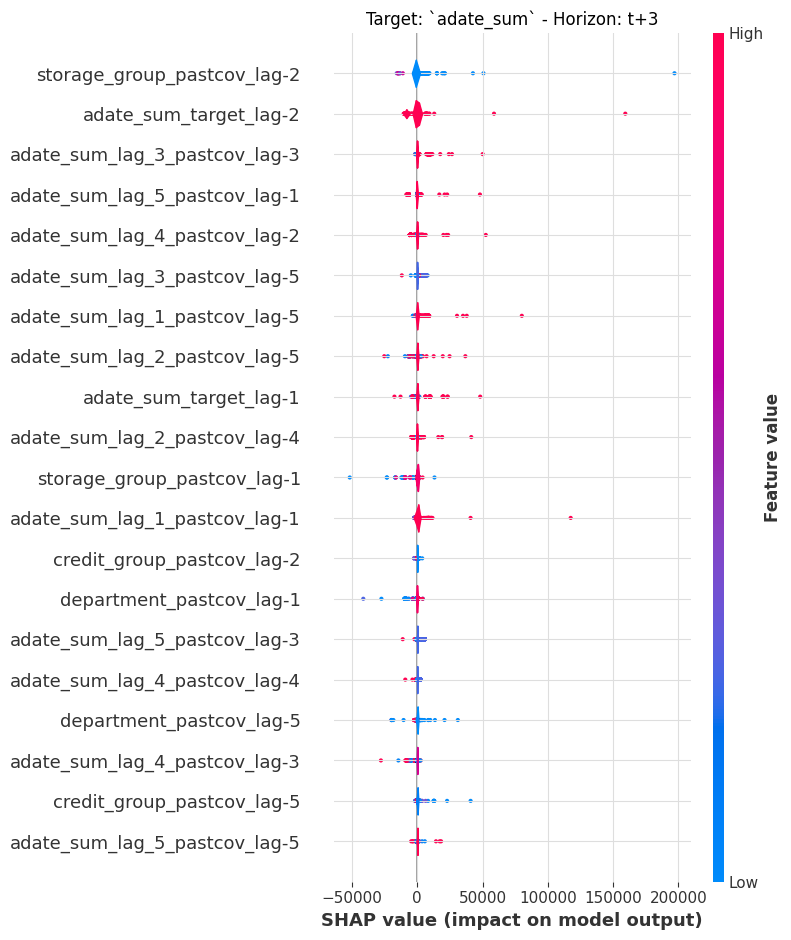

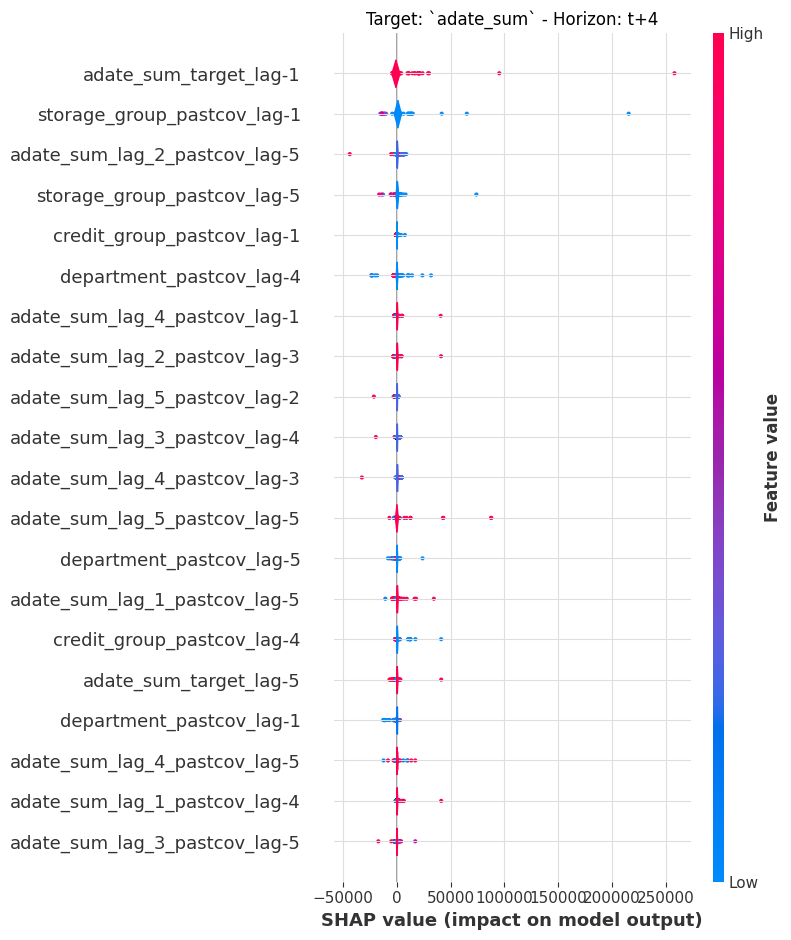

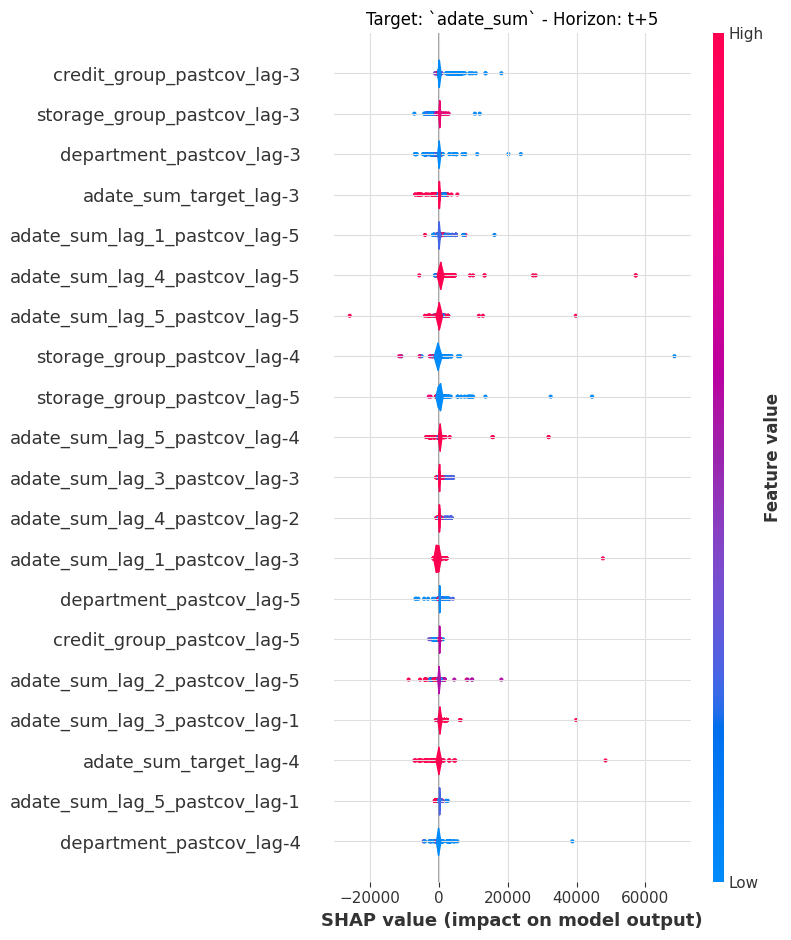

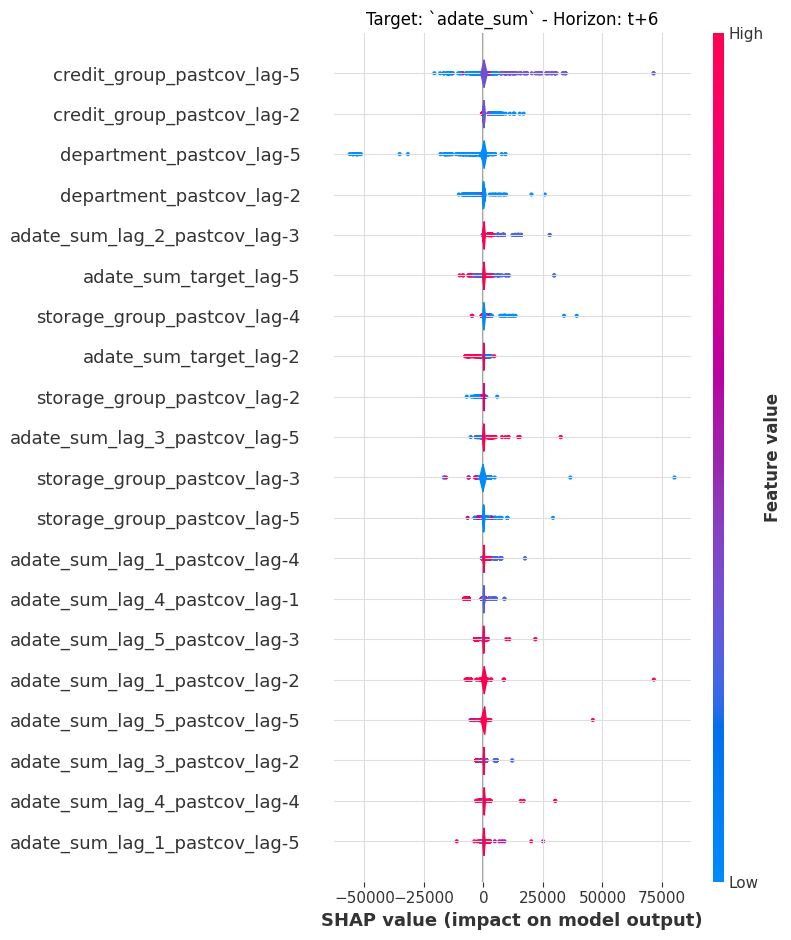

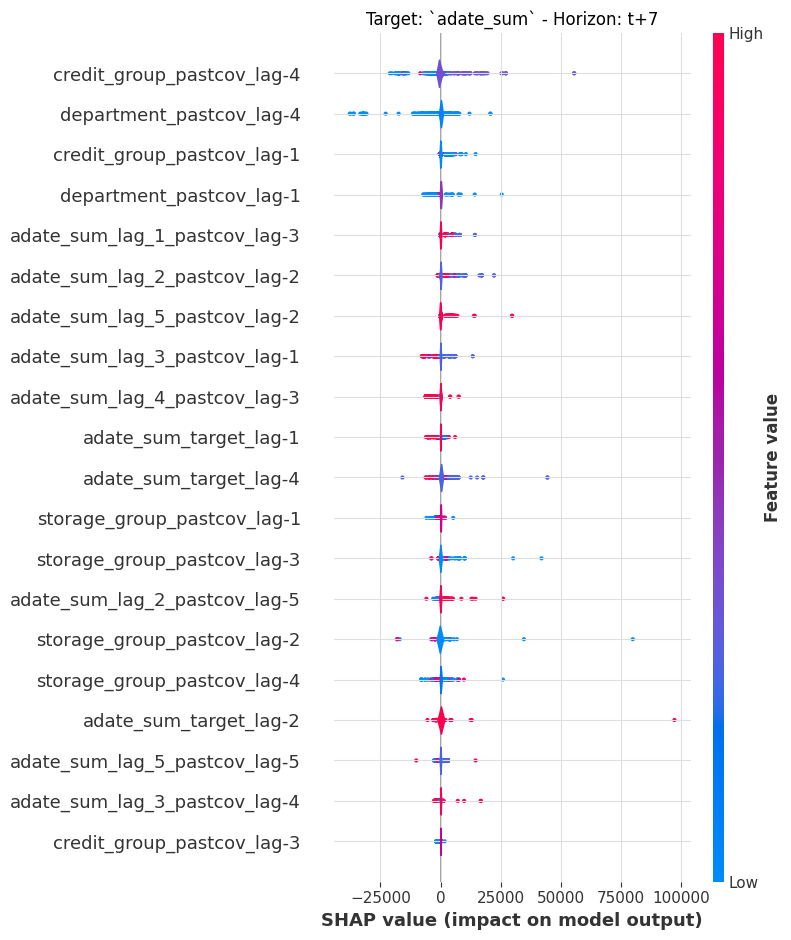

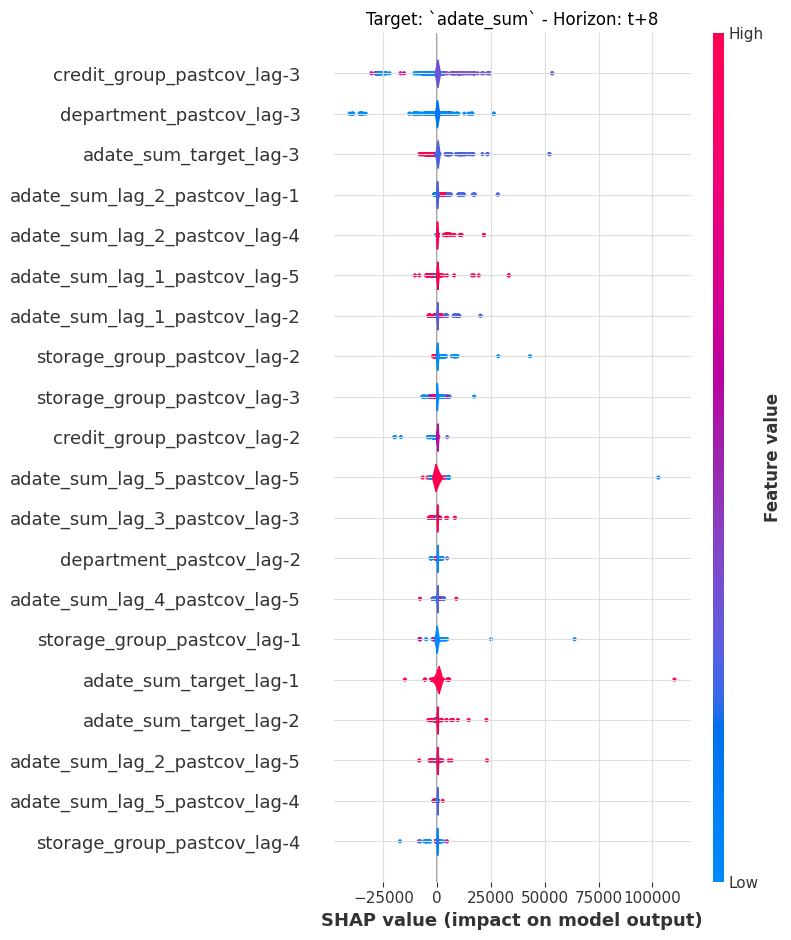

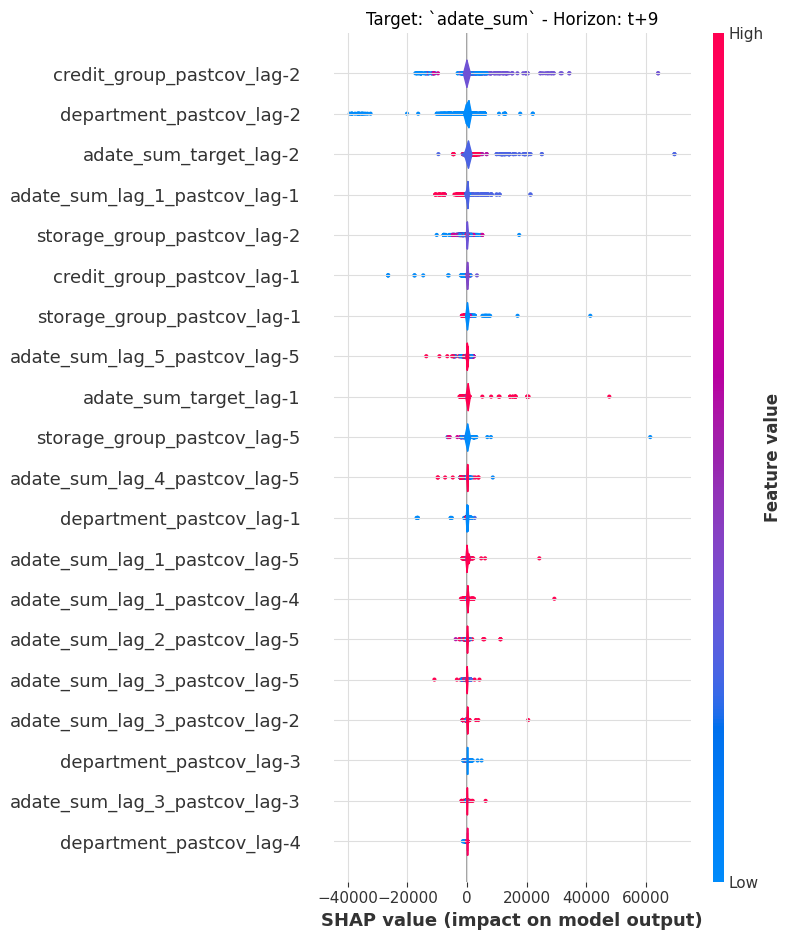

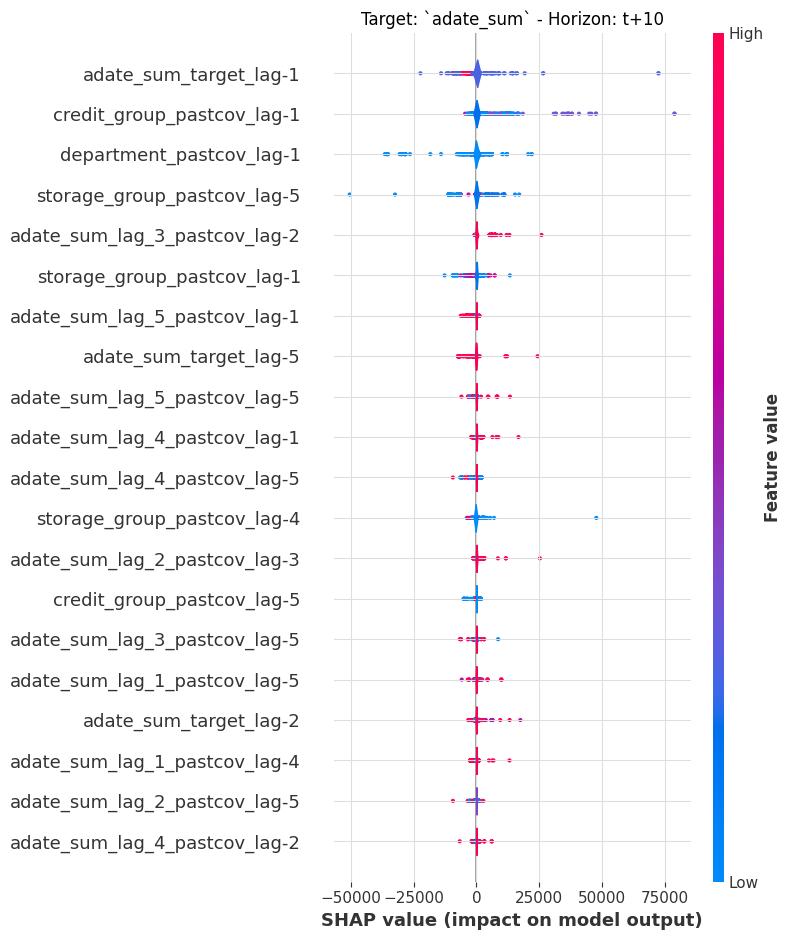

{1: {'adate_sum': .values =
  array([[-2.81823119e+00,  3.84610349e-02, -4.01406807e+01, ...,
           4.56631798e+00,  3.96078406e-02, -6.22275496e+01],
         [-2.32862267e+00, -4.26695407e+00, -4.14387684e+01, ...,
           8.01658849e+00,  3.96078406e-02,  1.04050556e+01],
         [ 1.76656931e+00,  6.47377100e+00,  3.51831574e+02, ...,
           4.56631798e+00,  3.96078406e-02,  1.49652604e+01],
         ...,
         [ 7.27836872e+00,  9.25511136e+01, -7.07917181e+01, ...,
           1.36942993e+01,  3.96078406e-02,  1.33888158e+01],
         [ 3.81388264e+00,  8.29456415e+00, -2.44665086e+01, ...,
           5.01027222e+00,  3.96078406e-02, -2.08045707e+01],
         [ 2.72929643e-01,  1.38973879e+01,  2.80724043e+02, ...,
           1.30283809e+01,  3.96078406e-02,  8.28698964e+00]])
  
  .base_values =
  array([719.75383074, 719.75383074, 719.75383074, ..., 719.75383074,
         719.75383074, 719.75383074])
  
  .data =
  array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 

In [16]:
shap_explain = ShapExplainer(models["CatBoost"])
results = shap_explain.explain()
shap_explain.summary_plot(plot_type = "violin")
# shap_explain.force_plot_from_ts()


In [17]:
# Difficult for me to do effectively
# ref: https://stats.stackexchange.com/a/8782
# Alternative model, create a model of sales per period using pandas and numpy to preserve as much data as possible.
# Convert intake to intake-per-period: 
# intake-per-period = observed intake / (n-periods w/o intake)


In [18]:
# Model performance visual comparisons
# results.sort_values(
#     by = ["RMSE", "Coverage Probability"]
#     ascending = [True, False]
# )

Potential Future Features:
- [ ] Hierarchical Modeling (e.g. by Department, by Credit, etc.)
- [ ] Popular ML models (ARIMA, RandomForest, MCMC, etc.)
- [ ] With Multi-variate Models, we can have SHAP feature importance explanation.
- [ ] Calculating Backlog durations.

# We're about the process!
If streamlining means less people work, we want less of it. Data belong to the social.